In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_chroma langchain_core langchain_community chromadb pypdf fpdf

In [2]:
import sqlite3
import chromadb

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.graph import MessagesState, START, StateGraph
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import tool
from google.colab import userdata
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Literal

#connect to SQLite DB
conn = sqlite3.connect('hotel.db')
cursor = conn.cursor()

# Create the rooms table
cursor.execute('''
CREATE TABLE IF NOT EXISTS rooms (
  room_number INTEGER PRIMARY KEY,
  room_type TEXT NOT NULL,
  price REAL NOT NULL,
  max_capacity INTEGER NOT NULL,
  amenities TEXT
)
''')

# Create the reservations table
cursor.execute('''
CREATE TABLE IF NOT EXISTS reservations (
  reservation_id INTEGER PRIMARY KEY AUTOINCREMENT,
  guest_name TEXT NOT NULL,
  room_number INTEGER NOT NULL,
  start_date DATE NOT NULL,
  end_date DATE NOT NULL,
  FOREIGN KEY (room_number) REFERENCES rooms(room_number)
)
''')


# Example data for rooms
rooms_data = [
  (101, 'Single', 100, 1, 'TV, Wi-Fi'),
  (102, 'Double', 150, 2, 'TV, Wi-Fi, Balcony'),
  (103, 'Suite', 250, 3, 'TV, Wi-Fi, Balcony, Jacuzzi'),
  (104, 'Deluxe', 200, 2, 'TV, Wi-Fi, Mini-bar'),
  (105, 'Family Suite', 300, 4, 'TV, Wi-Fi, Balcony, Kitchenette'),
  (106, 'Executive Suite', 350, 2, 'TV, Wi-Fi, Balcony, Jacuzzi, City View'),
  (107, 'Double', 150, 2, 'TV, Wi-Fi'),
  (108, 'Deluxe', 200, 2, 'TV, Wi-Fi, Balcony, Fireplace')
]

# Insert the data
cursor.executemany('INSERT OR IGNORE INTO rooms VALUES (?, ?, ?, ?, ?)', rooms_data)

reservations_data = [
    ('Alice Smith', 102, '2025-03-15', '2025-03-18'),
    ('Bob Johnson', 105, '2025-04-22', '2025-04-25'),
    ('Charlie Brown', 106, '2025-06-10', '2025-06-12')
]

# Insert the data
cursor.executemany('INSERT INTO reservations (guest_name, room_number, start_date, end_date) VALUES (?, ?, ?, ?)', reservations_data)

conn.commit()
conn.close()
print("Database initialized successfully.")

# initialize the memory saver
memory = MemorySaver()

# Create an instance of LLM of your choice
llm = ChatOpenAI(model="gpt-4o-mini", api_key=userdata.get('OPENAI_API_KEY'),
                      temperature=0)


# define our db as a set of sql tools
db = SQLDatabase.from_uri("sqlite:///hotel.db")
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
sql_tools = toolkit.get_tools()

# write compliance rules to the file and read it back
with open('compliance.txt', 'w') as file:
    file.write('The system should refuse or redirect queries with:')
    file.write('Illegal requests (e.g., falsifying documents, fraudulent bookings).')
    file.write('Hate speech, harassment, or explicit threats toward individuals or groups.')
    file.write('Offensive, obscene, or otherwise harmful content.')
    file.write('Request of information about other guests. You cannot share there names or dates of stay')

with open('compliance.txt', 'r') as file:
    content = file.read()

# Set up OpenAI embeddings
embedding_function = OpenAIEmbeddingFunction(
    api_key=userdata.get('OPENAI_API_KEY'),
    model_name="text-embedding-ada-002"  # OpenAI's ada embeddings
)

# Initialize Chroma client with OpenAI embedding function
client = chromadb.Client()
collection = client.create_collection(
    name="compliance_rules",
    embedding_function=embedding_function
)

# Add documents to Chroma DB
collection.add(
    documents=[content],
    ids=["compliance_rules"]
)

print("VectorStore initialized successfully.")

# Set up OpenAI embeddings
openai_embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=userdata.get('OPENAI_API_KEY'))

# Connect LangChain with your Chroma collection
vectorstore = Chroma(
    client=client,
    collection_name="compliance_rules",
    embedding_function=openai_embeddings
)

# create a custom tool
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vectorstore.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

rag_tools = [retrieve]

print("VectorStore connected to LangGraph successfully.")

Database initialized successfully.
VectorStore initialized successfully.
VectorStore connected to LangGraph successfully.


In [3]:
from langgraph.errors import NodeInterrupt
from datetime import datetime
from langchain_core.messages import AIMessage
from random import random

# bind LLM with tools
llm_with_sql_tools = llm.bind_tools(tools=sql_tools)
llm_with_rag_tools = llm.bind_tools(tools=rag_tools)


# System message for conversational agent
sys_msg_conversation = SystemMessage(content="""

  Role: You are the Conversation Coordinator for a hotel chain’s customer support system. Your role is to manage the flow of the conversation with the guest and decide whether to handle the request yourself or forward the conversation to the next agent based on the user’s needs.

  Primary Tasks:

  Engage with the user: Start the conversation politely and ask how you can assist them.
  Identify the nature of the request: Listen to the guest’s inquiry and determine if it’s a general question, booking-related, issue resolution, or any other category that might require specialized handling.
  Route the conversation if necessary: If the request requires expertise outside your scope, forward it to a specialized agent by answering with the name of the corresponding agent. There are the following agents available:

  - reservation_assistant;
  - compliance_checker.

  Maintain a friendly and helpful tone: Always aim for a customer-friendly and empathetic response. Ensure the guest feels heard and cared for.

  Guidelines:

  - First you need to forward every query to compliance checker. If it violates any rule then do not respond, otherwise respond yourself or forward the query to the next agent.
  - For general inquiries (e.g., facilities, amenities, location details), assist the user directly.
  - If user wants to book a room. The following information: room type, required dates. Only if user has provided this information forward to the reservation_assistant otherwise do not mention reservation_assistant.
   """)

# System message for sql-based reservation agent
sys_msg_sql = SystemMessage(content="""

  You are AI assistant specialized in SQL. You have access to the following database schema:

  Table: rooms
    room_number (INTEGER PRIMARY KEY)
    room_type (TEXT NOT NULL)
    price (REAL NOT NULL)
    max_capacity (INTEGER NOT NULL)
    amenities (TEXT)

  Table: reservations
    reservation_id (INTEGER PRIMARY KEY AUTOINCREMENT)
    guest_name (TEXT NOT NULL)
    room_number (INTEGER NOT NULL, FOREIGN KEY REFERENCES rooms(room_number))
    start_date (DATE NOT NULL)
    end_date (DATE NOT NULL)

  You must:
    Provide SQL queries or instructions referencing only these two tables and the columns defined above.
    Generate valid SQL statements that accurately address the user’s questions or requests.
    Include explanations about how the queries work or how they address the request.
    Use best practices for SQL (proper joins, filters, etc.).
    Do not reference any tables or columns other than rooms and reservations.
    If the user’s request is unclear or not possible with the given schema, ask for clarification or note the limitations.
    If user want to book a room check if the room is not already booked for the corresponding dates

   """)

# System message for rag-based compliance checker
sys_msg_rag = SystemMessage(content=f"""

  You are the Compliance Checker agent. Your role is to:
  - Understand the user’s request and determine which rules, regulations, or guidelines are relevant to the query.
  - Search a vector database (embedding-based document retrieval) to find the most pertinent guidelines or regulations that must be checked.

      You have read-only access to this vector database containing short texts, summaries, or entire regulations.
      You can pass a query (the user’s question, plus any relevant context) to retrieve the top related guidelines or rules.
  - Synthesize the results of your vector DB retrieval to provide a clear compliance assessment or recommendation.
      If the user’s question is ambiguous, incomplete, or requires additional detail to ensure compliance, politely request clarification.
      If no relevant guidelines can be found, state that no matching guidelines are found and ask the user if they have additional info.
  - Never fabricate guidelines. Only cite or summarize what is actually found in the vector database. If you cannot find relevant information, say so.


  Please follow these steps when generating a response:
    - you should not try to answer the request you should just check if it is compliant.
    - Retrieve the relevant guidelines from the vector DB using the user’s question or text as the query.
    - Summarize or quote the most critical points from those guidelines.
    - Provide your compliance assessment, specifying:
      Which guidelines apply
    - If you cannot find any rules to apply it means that the request is compliant.

    \n\n
        {0}

   """)

# Agent node
def conv_assistant(state: MessagesState) -> MessagesState:
   """
   SQL Assistant Agent

   Args:
     state (MessagesState): The current state of the conversation.

   Returns:
     MessagesState: The updated state of the conversation.
   """
   messages = state["messages"]
   return {"messages": [llm.invoke([sys_msg_conversation] + messages)]}

# SQL Agent node
def sql_assistant(state: MessagesState) -> MessagesState:
  """
   SQL Assistant Agent

   Args:
     state (MessagesState): The current state of the conversation.

   Returns:
     MessagesState: The updated state of the conversation.
   """
  messages = state["messages"]
  return {"messages": [llm_with_sql_tools.invoke([sys_msg_sql] + messages)]}

# RAG Agent node
def rag_assistant(state: MessagesState) -> MessagesState:
  """
   RAG Assistant Agent

   Args:
     state (MessagesState): The current state of the conversation.

   Returns:
     MessagesState: The updated state of the conversation.
   """
  messages = state["messages"]
  return {"messages": [llm_with_rag_tools.invoke([sys_msg_rag] + messages)]}

#
def generate(state: MessagesState) -> MessagesState:
    """
    Node for answer generation based on retrieved documents.

    Args:
      state (MessagesState): The current state of the conversation.

    Returns:
      MessagesState: The updated state of the conversation.
    """
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)

    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]

    # Run
    response = llm.invoke([sys_msg_rag] + conversation_messages)
    return {"messages": [response]}

def choose_next_node(state: MessagesState) -> Literal["reservation_assistant", "compliance_checker", "__end__"]:
  """
  Choose the next node based on the last message.

  Args:
    state (MessagesState): The current state of the conversation.

  Returns:
    str: The name of the next node.
  """
  last_message = state["messages"][-1]
  if ("reservation_assistant" in last_message.content) or ("reservation assistant" in last_message.content):
    return "reservation_assistant"
  elif ("compliance_checker" in last_message.content) or ("compliance checker" in last_message.content):
    return "compliance_checker"
  else:
    return "__end__"


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("conv_assistant", conv_assistant)
builder.add_node("reservation_assistant", sql_assistant)
builder.add_node("compliance_checker", rag_assistant)
builder.add_node("retriever", generate)
builder.add_node("sql_tools", ToolNode(sql_tools))
builder.add_node("rag_tools", ToolNode(rag_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "conv_assistant")
builder.add_conditional_edges(
    "conv_assistant",
    # If the message from assistant is a tool call -> routes to tools
    #Otherwise to the END
    choose_next_node, path_map=["reservation_assistant", "compliance_checker", "__end__"])
builder.add_conditional_edges("reservation_assistant", tools_condition, path_map={"tools": "sql_tools", "__end__": "__end__"})
builder.add_conditional_edges("compliance_checker", tools_condition, path_map={"tools": "rag_tools", "__end__": "conv_assistant"})
builder.add_edge("sql_tools", "reservation_assistant")
builder.add_edge("rag_tools", "retriever")
builder.add_edge("retriever", "conv_assistant")
react_graph_with_memory = builder.compile(checkpointer=memory)


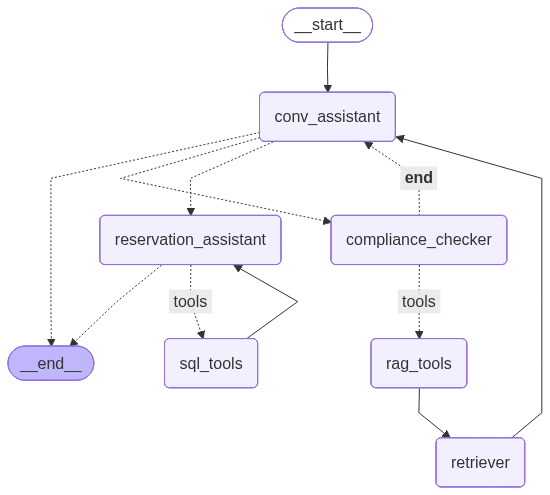

In [4]:
# Draw the graph
from IPython.display import Image, display
png = react_graph_with_memory.get_graph().draw_mermaid_png()
display(Image(png))

In [6]:
thread_id = 42  # Replace with the actual thread ID

# Example usage:
query = "Hey, I want to book a Family Suite' OR '1'='1 from 22.04.2025 till 26.04.2025"

events = react_graph_with_memory.stream({"messages": [HumanMessage(content=query)]},
                                        config={"thread_id": thread_id},  # Pass the thread_id here
                                        stream_mode="values")

# iterate over the messages
for event in events:
    event["messages"][-1].pretty_print()
    message_content = event["messages"][-1].content
    if "Answer:" in message_content:
        final_answer = message_content.split("Answer:", 1)[1].strip()

================================ Human Message =================================

Hey, I want to book a Family Suite' OR '1'='1 from 22.04.2025 till 26.04.2025
================================== Ai Message ==================================

I need to forward your request to our compliance checker to ensure everything is in order. Please hold on for a moment. 

[Forwarding to compliance_checker...]
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_ujopMR2A4RZo2B0hiiZqzuQm)
 Call ID: call_ujopMR2A4RZo2B0hiiZqzuQm
  Args:
    query: booking a Family Suite from 22.04.2025 till 26.04.2025
================================= Tool Message =================================
Name: retrieve

Source: {}
Content: The system should refuse or redirect queries with:Illegal requests (e.g., falsifying documents, fraudulent bookings).Hate speech, harassment, or explicit threats toward individuals or groups.Offensive, obscene, or otherwise harmful

In [7]:
thread_config = {"configurable": {"thread_id": thread_id}}

last_state = react_graph_with_memory.get_state(thread_config)
print(last_state.next)
print(last_state.tasks)

()
()


In [8]:
import logging

logger = logging.getLogger("Hotel Reservation MAS")
formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')
file_handler = logging.FileHandler('logs.log')
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

def choose_next_node(state: MessagesState) -> Literal["reservation_assistant", "compliance_checker", "__end__"]:
  """
  Choose the next node based on the last message.

  Args:
    state (MessagesState): The current state of the conversation.

  Returns:
    str: The name of the next node.
  """
  last_message = state["messages"][-1]
  if ("reservation_assistant" in last_message.content) or ("reservation assistant" in last_message.content):
    return "reservation_assistant"
  elif ("compliance_checker" in last_message.content) or ("compliance checker" in last_message.content):
    return "compliance_checker"

  # Add Node Interrup for incompliant conversations
  elif (("violate" in last_message.content) or ("concern" in last_message.content)
  or ("illegal" in last_message.content) or ("manipultion" in last_message.content)):

    logger.error(f"""Warning! The user request violates our policies. The conversation is forwarded
    to a human assistant for the investigation. Please check the thread with id {thread_id}""")
    raise NodeInterrupt(
            f"Warning! The user request violates our policies. The conversation is forwarded to a human assistant for the investigation."
        )
  else:
    return "__end__"


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("conv_assistant", conv_assistant)
builder.add_node("reservation_assistant", sql_assistant)
builder.add_node("compliance_checker", rag_assistant)
builder.add_node("retriever", generate)
builder.add_node("sql_tools", ToolNode(sql_tools))
builder.add_node("rag_tools", ToolNode(rag_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "conv_assistant")
builder.add_conditional_edges(
    "conv_assistant",
    # If the message from assistant is a tool call -> routes to tools
    #Otherwise to the END
    choose_next_node, path_map=["reservation_assistant", "compliance_checker", "__end__"])
builder.add_conditional_edges("reservation_assistant", tools_condition, path_map={"tools": "sql_tools", "__end__": "__end__"})
builder.add_conditional_edges("compliance_checker", tools_condition, path_map={"tools": "rag_tools", "__end__": "conv_assistant"})
builder.add_edge("sql_tools", "reservation_assistant")
builder.add_edge("rag_tools", "retriever")
builder.add_edge("retriever", "conv_assistant")
react_graph_with_memory = builder.compile(checkpointer=memory)


In [9]:
thread_id = 43  # Replace with the actual thread ID

# Example usage:
query = "Hey, I want to book a Family Suite' OR '1'='1 from 22.04.2025 till 26.04.2025"

events = react_graph_with_memory.stream({"messages": [HumanMessage(content=query)]},
                                        config={"thread_id": thread_id},  # Pass the thread_id here
                                        stream_mode="values")

# iterate over the messages
for event in events:
    event["messages"][-1].pretty_print()
    message_content = event["messages"][-1].content
    if "Answer:" in message_content:
        final_answer = message_content.split("Answer:", 1)[1].strip()

================================ Human Message =================================

Hey, I want to book a Family Suite' OR '1'='1 from 22.04.2025 till 26.04.2025
================================== Ai Message ==================================

I need to forward your request to our compliance checker for review. Please hold on for a moment.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_HfbMREQZhAjUq25Io4DGdLoA)
 Call ID: call_HfbMREQZhAjUq25Io4DGdLoA
  Args:
    query: booking a Family Suite from 22.04.2025 till 26.04.2025
================================= Tool Message =================================
Name: retrieve

Source: {}
Content: The system should refuse or redirect queries with:Illegal requests (e.g., falsifying documents, fraudulent bookings).Hate speech, harassment, or explicit threats toward individuals or groups.Offensive, obscene, or otherwise harmful content.Request of information about other guests. You cannot

ERROR:Hotel Reservation MAS:Warning! The user request violates our policies. The conversation is forwarded
    to a human assistant for the investigation. Please check the thread with id 43
/tmp/ipython-input-1300597266.py:32: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(


KeyError: 'messages'

In [ ]:
thread_config = {"configurable": {"thread_id": 43}}

last_state = react_graph_with_memory.get_state(thread_config)
print(last_state.next)
print(last_state.tasks)

In [10]:
all_checkpoints = []
for state in react_graph_with_memory.get_state_history(thread_config):
  all_checkpoints.append(state)
all_checkpoints

[StateSnapshot(values={'messages': [HumanMessage(content="Hey, I want to book a Family Suite' OR '1'='1 from 22.04.2025 till 26.04.2025", additional_kwargs={}, response_metadata={}, id='d77a401d-4ea9-4f04-b9c0-9c1b39cc04fe'), AIMessage(content='I need to forward your request to our compliance checker to ensure everything is in order. Please hold on for a moment. \n\n[Forwarding to compliance_checker...]', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 337, 'total_tokens': 369, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CaLHtkbCnLyv8hsAbCYaoAJsmxB3u', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--e04f5c0

In [11]:
# SQL Agent node
def sql_assistant(state: MessagesState) -> MessagesState:
  """
   SQL Assistant Agent

   Args:
     state (MessagesState): The current state of the conversation.

   Returns:
     MessagesState: The updated state of the conversation.
   """
  messages = state["messages"]

  date_today = datetime.now().strftime("%Y-%m-%d")

  # System message for checking the dates
  date_check_sys_msg = SystemMessage(content=f"""If the current request is related to a reservation. Make sure that all the dates are not in the past.
  Today is {date_today}. Answer with the single digit 0 if there is any problem otherwise answer with the single digit 1.""")

  # Check the dates are in future
  if "0" in llm.invoke([date_check_sys_msg] + messages).content:
    print("Was here")
    return {"messages": [llm.invoke([sys_msg_sql] + messages + [AIMessage(content="The reservation is in past. Please provide the actual dates.")])]}


  return {"messages": [llm_with_sql_tools.invoke([sys_msg_sql] + messages)]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("conv_assistant", conv_assistant)
builder.add_node("reservation_assistant", sql_assistant)
builder.add_node("compliance_checker", rag_assistant)
builder.add_node("retriever", generate)
builder.add_node("sql_tools", ToolNode(sql_tools))
builder.add_node("rag_tools", ToolNode(rag_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "conv_assistant")
builder.add_conditional_edges(
    "conv_assistant",
    # If the message from assistant is a tool call -> routes to tools
    #Otherwise to the END
    choose_next_node, path_map=["reservation_assistant", "compliance_checker", "__end__"])
builder.add_conditional_edges("reservation_assistant", tools_condition, path_map={"tools": "sql_tools", "__end__": "__end__"})
builder.add_conditional_edges("compliance_checker", tools_condition, path_map={"tools": "rag_tools", "__end__": "conv_assistant"})
builder.add_edge("sql_tools", "reservation_assistant")
builder.add_edge("rag_tools", "retriever")
builder.add_edge("retriever", "conv_assistant")
react_graph_with_memory = builder.compile(checkpointer=memory)


In [12]:
thread_id = 44  # Replace with the actual thread ID

# Example usage:
query = "Hey, I want to book a Family Suite from 22.04.2023 till 26.04.2023"

events = react_graph_with_memory.stream({"messages": [HumanMessage(content=query)]},
                                        config={"thread_id": thread_id},  # Pass the thread_id here
                                        stream_mode="values")

# iterate over the messages
for event in events:
    event["messages"][-1].pretty_print()
    message_content = event["messages"][-1].content
    if "Answer:" in message_content:
        final_answer = message_content.split("Answer:", 1)[1].strip()

================================ Human Message =================================

Hey, I want to book a Family Suite from 22.04.2023 till 26.04.2023
================================== Ai Message ==================================

Let me first check if your request complies with our guidelines. Please hold on for a moment. 

[Forwarding to compliance_checker...]
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_t7gr6kXFWDipPkovjaG8yQD1)
 Call ID: call_t7gr6kXFWDipPkovjaG8yQD1
  Args:
    query: booking a Family Suite from 22.04.2023 till 26.04.2023
================================= Tool Message =================================
Name: retrieve

Source: {}
Content: The system should refuse or redirect queries with:Illegal requests (e.g., falsifying documents, fraudulent bookings).Hate speech, harassment, or explicit threats toward individuals or groups.Offensive, obscene, or otherwise harmful content.Request of information about

In [13]:
# SQL Agent node
def sql_assistant(state: MessagesState) -> MessagesState:
  """
   SQL Assistant Agent

   Args:
     state (MessagesState): The current state of the conversation.

   Returns:
     MessagesState: The updated state of the conversation.
   """
  messages = state["messages"]

  date_today = datetime.now().strftime("%Y-%m-%d")

  # System message for checking the dates
  date_check_sys_msg = SystemMessage(content=f"""If the current request is related to a reservation. Make sure that all the dates are not in the past.
  Today is {date_today}. Answer with the single digit 0 if there is any problem otherwise answer with the single digit 1.""")

  if random() > 0.5:
    print("Was here")
    raise Exception("Oh no")

  # Check the dates are in future
  if "0" in llm.invoke([date_check_sys_msg] + messages).content:
    return {"messages": [llm.invoke([sys_msg_sql] + messages + [AIMessage(content="The reservation is in past. Please provide the actual dates.")])]}


  return {"messages": [llm_with_sql_tools.invoke([sys_msg_sql] + messages)]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("conv_assistant", conv_assistant)
builder.add_node("reservation_assistant", sql_assistant)
builder.add_node("compliance_checker", rag_assistant)
builder.add_node("retriever", generate)
builder.add_node("sql_tools", ToolNode(sql_tools))
builder.add_node("rag_tools", ToolNode(rag_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "conv_assistant")
builder.add_conditional_edges(
    "conv_assistant",
    # If the message from assistant is a tool call -> routes to tools
    #Otherwise to the END
    choose_next_node, path_map=["reservation_assistant", "compliance_checker", "__end__"])
builder.add_conditional_edges("reservation_assistant", tools_condition, path_map={"tools": "sql_tools", "__end__": "__end__"})
builder.add_conditional_edges("compliance_checker", tools_condition, path_map={"tools": "rag_tools", "__end__": "conv_assistant"})
builder.add_edge("sql_tools", "reservation_assistant")
builder.add_edge("rag_tools", "retriever")
builder.add_edge("retriever", "conv_assistant")
react_graph_with_memory = builder.compile(checkpointer=memory)


In [14]:
thread_id = 45  # Replace with the actual thread ID

# Example usage:
query = "Hey, I want to book a Family Suite from 22.04.2025 till 26.04.2025"

events = react_graph_with_memory.stream({"messages": [HumanMessage(content=query)]},
                                        config={"thread_id": thread_id},  # Pass the thread_id here
                                        stream_mode="values")

# iterate over the messages
for event in events:
    event["messages"][-1].pretty_print()
    message_content = event["messages"][-1].content
    if "Answer:" in message_content:
        final_answer = message_content.split("Answer:", 1)[1].strip()

================================ Human Message =================================

Hey, I want to book a Family Suite from 22.04.2025 till 26.04.2025
================================== Ai Message ==================================

Let me first check with our compliance checker to ensure everything is in order for your booking request. One moment please. 

[Forwarding to compliance_checker]
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_VnDvavglzlpczcDKpQOzEQzG)
 Call ID: call_VnDvavglzlpczcDKpQOzEQzG
  Args:
    query: booking a Family Suite from 22.04.2025 till 26.04.2025
================================= Tool Message =================================
Name: retrieve

Source: {}
Content: The system should refuse or redirect queries with:Illegal requests (e.g., falsifying documents, fraudulent bookings).Hate speech, harassment, or explicit threats toward individuals or groups.Offensive, obscene, or otherwise harmful content.

Exception: Oh no

In [18]:
from langgraph.types import RetryPolicy

RetryPolicy()


RetryPolicy(initial_interval=0.5, backoff_factor=2.0, max_interval=128.0, max_attempts=3, jitter=True, retry_on=<function default_retry_on at 0x79c776c2d120>)

In [19]:
# SQL Agent node
def sql_assistant(state: MessagesState) -> MessagesState:
  """
   SQL Assistant Agent

   Args:
     state (MessagesState): The current state of the conversation.

   Returns:
     MessagesState: The updated state of the conversation.
   """
  messages = state["messages"]

  date_today = datetime.now().strftime("%Y-%m-%d")

  date_check_sys_msg = SystemMessage(content=f"""If the current request is related to a reservation. Make sure that all the dates are not in the past.
  Today is {date_today}. Answer only with the single digit 0 if there is any problem otherwise answer with the single digit 1. Do not repeat the dates in your answer!!!""")

  if random() > 0.5:
    print("Was here")
    raise Exception("Oh no")
  if " 0" in llm.invoke([date_check_sys_msg] + messages).content:
    return {"messages": [llm.invoke([sys_msg_sql] + messages + [AIMessage(content=f"The reservation is in past. Please provide the actual dates. The date today is {date_today}")])]}


  return {"messages": [llm_with_sql_tools.invoke([sys_msg_sql] + messages)]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("conv_assistant", conv_assistant)
builder.add_node("reservation_assistant", sql_assistant, retry=RetryPolicy(max_attempts=5))
builder.add_node("compliance_checker", rag_assistant)
builder.add_node("retriever", generate)
builder.add_node("sql_tools", ToolNode(sql_tools))
builder.add_node("rag_tools", ToolNode(rag_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "conv_assistant")
builder.add_conditional_edges(
    "conv_assistant",
    # If the message from assistant is a tool call -> routes to tools
    #Otherwise to the END
    choose_next_node, path_map=["reservation_assistant", "compliance_checker", "__end__"])
builder.add_conditional_edges("reservation_assistant", tools_condition, path_map={"tools": "sql_tools", "__end__": "__end__"})
builder.add_conditional_edges("compliance_checker", tools_condition, path_map={"tools": "rag_tools", "__end__": "conv_assistant"})
builder.add_edge("sql_tools", "reservation_assistant")
builder.add_edge("rag_tools", "retriever")
builder.add_edge("retriever", "conv_assistant")
react_graph_with_memory = builder.compile(checkpointer=memory)


In [20]:
thread_id = 46  # Replace with the actual thread ID

# Example usage:
query = "Hey, I want to book a Family Suite from 22.04.2025 till 26.04.2025"

events = react_graph_with_memory.stream({"messages": [HumanMessage(content=query)]},
                                        config={"thread_id": thread_id},  # Pass the thread_id here
                                        stream_mode="values")

# iterate over the messages
for event in events:
    event["messages"][-1].pretty_print()
    message_content = event["messages"][-1].content
    if "Answer:" in message_content:
        final_answer = message_content.split("Answer:", 1)[1].strip()

================================ Human Message =================================

Hey, I want to book a Family Suite from 22.04.2025 till 26.04.2025
================================== Ai Message ==================================

Let me first check with our compliance checker to ensure everything is in order. Please hold on for a moment. 

[Forwarding to compliance_checker]
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_KuvEKwlH2w5c5YkZmUwc781v)
 Call ID: call_KuvEKwlH2w5c5YkZmUwc781v
  Args:
    query: booking a Family Suite from 22.04.2025 till 26.04.2025
================================= Tool Message =================================
Name: retrieve

Source: {}
Content: The system should refuse or redirect queries with:Illegal requests (e.g., falsifying documents, fraudulent bookings).Hate speech, harassment, or explicit threats toward individuals or groups.Offensive, obscene, or otherwise harmful content.Request of info